In [278]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.utils import resample
import ast
%matplotlib inline

### Load data (pre-processed in clean.ipynb) and define useful constants

In [291]:
# load data
# res = pd.read_csv("results/results_cleaned.csv")
res = pd.read_csv("results/results_cleaned_no_outliers.csv").sort_values('timestamp').reset_index()

# required fields
ids = ['timestamp','postId','workerId','mode']

# interactions
inter = ['timestamp','postId','workerId','mode','interaction','UrlChanges', 'highUrlChanges', 
       'lowUrlChanges', 'medUrlChanges', 'model', 'pop_time']

modes = ["List", "Category", "Pairwise"]

In [292]:
# compute bootstrapped confidence interval
def bootstrap_mean(data, n_bootstraps):
    bootstraps = []
    for i in range(n_bootstraps):
        # Sample with replacement from data
        bootstraps.append(resample(data).mean())
    return pd.Series(bootstraps)

In [293]:
# # should we change the interactions to just be add remove? 
# # can tell by url if high low etc

# res.replace(to_replace=['ADD', 'HIGH ADD', 'LOW ADD', 'LEFT ADD', 'RIGHT ADD'], value ='ADD', inplace=True)
# res.replace(to_replace=['REMOVE', 'HIGH REMOVE', 'LOW REMOVE', 'LEFT REMOVE', 'RIGHT REMOVE'], value ='REMOVE', inplace=True)

In [294]:
inter_l = ['timestamp','workerId','mode','interaction','UrlChanges'] 
inter_c = ['timestamp','workerId','mode','interaction','highUrlChanges', 'lowUrlChanges', 'medUrlChanges']
inter_p = ['timestamp','workerId','mode','interaction','highUrlChanges', 'lowUrlChanges']

ints = {}
ints['l'] = res[inter_l][res['mode']=='List'].drop_duplicates(subset=['workerId','interaction','UrlChanges'])
ints['c'] = res[inter_c][res['mode']=='Category'].drop_duplicates(subset=['workerId','interaction','highUrlChanges', 
                                                                'lowUrlChanges', 'medUrlChanges'])
ints['p'] = res[inter_p][res['mode']=='Pairwise'].drop_duplicates(subset=['workerId','interaction','highUrlChanges', 
                                                                'lowUrlChanges'])

In [296]:
c =ints['c']
c = c[c['workerId']=='A1FLEFIVFT809G']


In [297]:
m = c[['highUrlChanges','medUrlChanges','lowUrlChanges','interaction']].transpose()
for i,s in enumerate(m.columns.values):
    m[s].loc[['lowUrlChanges','medUrlChanges','highUrlChanges']] = m[s].loc[['lowUrlChanges','medUrlChanges','highUrlChanges']].apply(lambda x: np.array(ast.literal_eval(x)).astype(np.int))
m.head()

ValueError: malformed node or string: nan

,75,76,77,78,79,80,81,82,83,84,...,158,161,162,163,164,165,166,167,168,169
highUrlChanges,[206],[206],[206],[206],[206],[206],[206],"[206, 122]","[122, 206, 198]","[122, 206, 198]",...,"[51, 201, 207, 205, 167, 156, 11, 122, 38, 199...","[51, 201, 207, 205, 167, 156, 11, 122, 38, 199...","[51, 201, 207, 205, 167, 156, 11, 122, 38, 199...","[51, 201, 207, 205, 167, 156, 11, 122, 38, 199...","[51, 201, 207, 205, 167, 156, 11, 122, 38, 199...","[51, 201, 207, 205, 167, 156, 11, 122, 38, 199...","[51, 201, 207, 205, 167, 156, 11, 122, 38, 199...","[51, 201, 207, 205, 167, 156, 11, 122, 38, 199...","[51, 201, 207, 205, 167, 156, 11, 122, 38, 199...","[51, 201, 207, 205, 167, 156, 11, 122, 38, 199..."
medUrlChanges,[],[85],[],[],[200],[],[],[],[],[203],...,"[45, 30, 104, 185, 224, 49, 216, 168, 52, 228,...","[45, 30, 104, 185, 224, 49, 216, 168, 52, 228,...","[45, 30, 104, 185, 224, 49, 216, 168, 52, 228,...","[45, 30, 104, 185, 224, 49, 216, 168, 52, 228,...","[102, 45, 30, 104, 185, 224, 49, 216, 168, 52,...","[102, 82, 45, 30, 104, 185, 224, 49, 216, 168,...","[82, 102, 45, 30, 104, 185, 224, 49, 216, 168,...","[82, 214, 102, 45, 30, 104, 185, 224, 49, 216,...","[82, 214, 102, 45, 30, 104, 185, 224, 49, 216,...","[3, 82, 214, 102, 45, 30, 104, 185, 224, 49, 2..."
lowUrlChanges,[],[],[],[85],[85],[85],"[200, 85]","[200, 85]","[200, 85]","[200, 85]",...,"[170, 34, 70, 221, 189, 79, 169, 35, 154, 90, ...","[170, 34, 70, 221, 189, 79, 169, 35, 154, 90, ...","[170, 34, 70, 221, 189, 79, 169, 35, 154, 90, ...","[170, 34, 70, 221, 189, 79, 169, 35, 154, 90, ...","[170, 34, 70, 221, 189, 79, 169, 35, 154, 90, ...","[170, 34, 70, 221, 189, 79, 169, 35, 154, 90, ...","[133, 170, 34, 70, 221, 189, 79, 169, 35, 154,...","[133, 170, 34, 70, 221, 189, 79, 169, 35, 154,...","[133, 170, 212, 34, 70, 221, 189, 79, 169, 35,...","[133, 212, 170, 34, 70, 221, 189, 79, 169, 35,..."
interaction,HIGH ADD,MED ADD,MED REMOVE,LOW ADD,MED ADD,MED REMOVE,LOW ADD,HIGH ADD,HIGH ADD,MED ADD,...,HIGH ADD,HIGH ADD,HIGH ADD,HIGH ADD,MED ADD,MED ADD,LOW ADD,MED ADD,LOW ADD,MED ADD


In [277]:
diffs = pd.DataFrame(columns=m.columns.values)
for i,s in enumerate(m.columns.values):
    if i<len(m.columns.values)-1:
        nxt = m.columns.values[i+1]
        row =[]
        for j in ['lowUrlChanges','medUrlChanges','highUrlChanges']:
#             print(m[s][j])
#             print(np.setxor1d(m[s][j], m[m.columns.values[i+1]][j]))
            row.append(np.setxor1d(m[s][j], m[nxt][j]))
        row.append(m[nxt].loc['interaction'])
        diffs[s] = row
diffs


,3,80,112,122,126,146,166,234,235,291,...,2735,2743,2785,2808,2813,2828,2835,3021,3057,3234
0,"[23, 63, 87, 107, 110, 162, 165, 166, 183, 200...","[129, 137, 170, 210]","[23, 63, 85, 87, 107, 110, 129, 137, 162, 165,...","[5, 23, 34, 63, 66, 70, 71, 85, 87, 107, 110, ...","[5, 34, 66, 70, 71, 87, 129, 137, 149, 165, 17...","[87, 129, 137, 165, 210]","[5, 22, 34, 35, 66, 70, 71, 79, 91, 149, 163, ...","[22, 35, 79, 91, 163, 189, 192]","[5, 34, 66, 70, 71, 87, 129, 137, 149, 165, 17...","[63, 107, 110, 166, 183]",...,"[5, 22, 34, 63, 66, 70, 71, 87, 107, 110, 129,...","[34, 63, 66, 70, 71, 87, 107, 110, 129, 137, 1...","[23, 34, 63, 66, 70, 71, 87, 107, 110, 129, 13...",[203],"[5, 22, 23, 34, 35, 63, 66, 70, 71, 79, 87, 90...","[5, 22, 34, 35, 66, 70, 71, 79, 90, 91, 149, 1...","[5, 22, 34, 35, 66, 70, 71, 79, 90, 91, 149, 1...","[5, 22, 34, 35, 66, 70, 71, 79, 90, 91, 137, 1...","[34, 66, 70, 71, 137, 149, 170, 213, 221]",NaN
1,"[21, 45, 81, 104, 120, 219]",[38],"[21, 38, 45, 81, 104, 120, 219]","[11, 21, 30, 45, 49, 52, 81, 104, 120, 168, 21...","[11, 30, 49, 52, 81, 104, 168, 216, 228]","[81, 104]","[30, 49, 52, 168, 216, 224, 228]","[49, 224]","[30, 52, 104, 168, 216, 228]","[21, 81]",...,"[21, 30, 45, 49, 52, 81, 104, 168, 216, 224, 228]","[21, 30, 45, 52, 81, 104, 168, 228]","[21, 30, 45, 52, 81, 104, 120, 168, 228]",[219],"[21, 30, 45, 49, 52, 81, 104, 120, 168, 185, 2...","[30, 49, 52, 168, 185, 216, 224, 228]","[30, 49, 52, 82, 102, 168, 185, 216, 224, 228]","[30, 49, 52, 82, 102, 168, 185, 216, 224, 228]","[30, 52, 168, 228]",NaN
2,"[0, 32, 122, 141, 145, 198, 207]",[199],"[0, 32, 122, 141, 145, 198, 199, 207]","[0, 32, 38, 122, 141, 145, 156, 198, 199, 207]","[38, 156, 199]",[199],"[11, 38, 156, 167]","[11, 167]","[38, 104, 156, 199]","[104, 141, 207]",...,"[11, 32, 38, 141, 145, 156, 167, 199, 207]","[32, 38, 141, 145, 199, 207]","[0, 32, 38, 141, 145, 199, 207]",[198],"[0, 11, 32, 38, 141, 145, 156, 167, 198, 199, ...","[11, 156, 167]","[11, 44, 51, 83, 146, 156, 167, 201, 205]","[11, 38, 44, 51, 83, 146, 156, 167, 199, 201, ...","[38, 156, 199]",NaN
3,LOW ADD,MED ADD,MED REMOVE,MED ADD,LOW ADD,LOW ADD,LOW ADD,LOW REMOVE,HIGH ADD,HIGH ADD,...,MED ADD,MED ADD,MED ADD,HIGH ADD,MED ADD,MED REMOVE,MED ADD,LOW ADD,HIGH ADD,NaN


In [268]:
to_swap = []
to_drop = []
for i,s in enumerate(diffs.columns.values):
    if diffs[s][3] in ['LOW REMOVE', 'HIGH REMOVE', 'MED REMOVE']:
        nxt = diffs.columns.values[i+1]
        for j in [0,1,2]:
            if not diffs[s][j].size ==0:
                v = diffs[s][j][0]
                for k in [0,1,2]:
                    if not j==k and not diffs[nxt][k].size ==0:
                        w = diffs[nxt][k][0]
                        if w == v:
                            to_drop.append(nxt+1)
                            to_swap.append(nxt) 

In [269]:
c.loc[to_swap,'interaction'] = 'SWAP'
c.drop(to_drop)

,timestamp,workerId,mode,interaction,highUrlChanges,lowUrlChanges,medUrlChanges
75,2018-08-29 18:21:02.229,A1FLEFIVFT809G,Category,HIGH ADD,['206'],[],[]
76,2018-08-29 18:21:06.324,A1FLEFIVFT809G,Category,MED ADD,['206'],[],['85']
77,2018-08-29 18:21:06.735,A1FLEFIVFT809G,Category,MED REMOVE,['206'],[],[]
79,2018-08-29 18:21:08.636,A1FLEFIVFT809G,Category,MED ADD,['206'],['85'],['200']
80,2018-08-29 18:21:09.378,A1FLEFIVFT809G,Category,MED REMOVE,['206'],['85'],[]
82,2018-08-29 18:21:11.668,A1FLEFIVFT809G,Category,HIGH ADD,"['206', '122']","['200', '85']",[]
83,2018-08-29 18:21:15.225,A1FLEFIVFT809G,Category,HIGH ADD,"['122', '206', '198']","['200', '85']",[]
84,2018-08-29 18:21:20.648,A1FLEFIVFT809G,Category,MED ADD,"['122', '206', '198']","['200', '85']",['203']
85,2018-08-29 18:21:21.229,A1FLEFIVFT809G,Category,LOW ADD,"['122', '206', '198']","['203', '200', '85']",[]
86,2018-08-29 18:21:26.611,A1FLEFIVFT809G,Category,MED ADD,"['122', '206', '198']","['203', '200', '85']",['219']


In [215]:
changes = []
for i,s in enumerate(diffs.columns.values):
    r = np.concatenate(diffs[s]).ravel()
    changes.append(r)

ValueError: zero-dimensional arrays cannot be concatenated

In [216]:
changes

[array([85]),
 array([85]),
 array([85]),
 array([200]),
 array([200]),
 array([200]),
 array([122]),
 array([198]),
 array([203]),
 array([203, 203]),
 array([219]),
 array([23]),
 array([0]),
 array([120]),
 array([32]),
 array([45]),
 array([162]),
 array([145]),
 array([207]),
 array([21]),
 array([63]),
 array([141]),
 array([110]),
 array([110]),
 array([110]),
 array([166]),
 array([107]),
 array([183]),
 array([81]),
 array([104]),
 array([104]),
 array([104]),
 array([], dtype=int64),
 array([87]),
 array([87, 87]),
 array([165]),
 array([129]),
 array([210]),
 array([199]),
 array([137]),
 array([137]),
 array([137]),
 array([], dtype=int64),
 array([170]),
 array([38]),
 array([38]),
 array([38]),
 array([34]),
 array([71]),
 array([66]),
 array([149]),
 array([70]),
 array([213]),
 array([30]),
 array([228]),
 array([52]),
 array([168]),
 array([221]),
 array([156]),
 array([5]),
 array([5, 5]),
 array([216]),
 array([216]),
 array([216]),
 array([49]),
 array([11]),
 array

In [89]:
c = c[['highUrlChanges','medUrlChanges','lowUrlChanges']].transpose()
for i in c.columns.values:
    c[i] = np.setdiff1d(c[i], c[i+1])

ValueError: Length of values does not match length of index

In [ ]:
 = ints['c'][ints['c']['interaction'].isin(['LOW REMOVE', 'HIGH REMOVE', 'MED REMOVE'])].groupby('workerId').count()['interaction']

In [63]:
adds={}
removes={}
ranks = {}
for i in ints:
    ints[i] = ints[i].groupby(['workerId']).apply(pd.DataFrame.sort_values, 'timestamp')
    ints[i] = ints[i].reset_index(drop=True)
    ints[i].dropna(subset =['interaction'])

In [63]:
adds={}
removes={}
ranks = {}
for i in ints:
    ints[i] = ints[i].groupby(['workerId']).apply(pd.DataFrame.sort_values, 'timestamp')
    ints[i] = ints[i].reset_index(drop=True)
    ints[i].dropna(subset =['interaction'])

In [64]:
adds = {}
adds['List'] = ints['l'][ints['l']['interaction'] == 'ADD'].groupby('workerId').count()['interaction']
adds['Category'] = ints['c'][ints['c']['interaction'].isin(['LOW ADD', 'HIGH ADD', 'MED ADD'])].groupby('workerId').count()['interaction']
adds['Pairwise'] = ints['p'][ints['p']['interaction'].isin(['LEFT ADD', 'RIGHT ADD'])].groupby('workerId').count()['interaction']

removes = {}
removes['List'] = ints['l'][ints['l']['interaction'] == 'REMOVE'].groupby('workerId').count()['interaction']
removes['Category'] = ints['c'][ints['c']['interaction'].isin(['LOW REMOVE', 'HIGH REMOVE', 'MED REMOVE'])].groupby('workerId').count()['interaction']
removes['Pairwise'] = ints['p'][ints['p']['interaction'].isin(['LEFT REMOVE', 'RIGHT REMOVE'])].groupby('workerId').count()['interaction']

In [65]:
adds['Category']

workerId
A11BSFO4LMHPXQ     12
A15SUPIZ05ZFCD     41
A1FLEFIVFT809G     85
A1JGA15NKUP0BB      3
A1NBX7UHTU5CKG     48
A1TARNH07A75CG     22
A1TYP11M6YZUK8    254
A28T38MOUG43YD     12
A2BADLL5Q78E7D    231
A2CIFCKECOSW0S    313
A2T5UVJCDX3C5      10
A39K5MR4MCSC56    325
A3DLPY6ABKCXSI     15
A3TOHZTNKOTFQL     13
A3TUJHF9LW3M8N     12
Name: interaction, dtype: int64

In [49]:
adds['List']

workerId
A1JQ4KBFW7U3N1     4
A1PP6DN7HB6Q9P    14
A1PTH9KTRO06EG    12
A1T6IYPL8THZ4H     7
A1VR49TB3Q4BV8    12
A1YILFU07P6DND     9
A3MK7F6KT80AZT    11
A3NBGNDNDGF10U     8
A5IELMRC1OIQO     13
AG7C4X3WKKBV      14
AKQPDAOVGFB91      3
AQKB8JSBEMXK9     13
AZZA3J049G7R5      4
Name: interaction, dtype: int64

In [50]:
adds['Pairwise']

workerId
A1P6OXEJ86HQRM    14
A1Q9DQOLJB8O83    18
A2CF2BD4Q0ZDJN    18
A2LR1HKNOVDTJ8     3
A3L62PZ2PQU34S     2
Name: interaction, dtype: int64

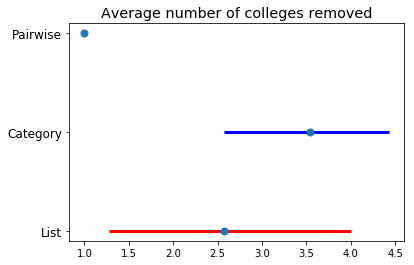

In [51]:
boot = pd.DataFrame()
for m in modes:
    boot[m] = bootstrap_mean(removes[m], 1000)
    
mean = boot.mean()
err = []
err.append((boot.apply(lambda x : np.percentile(x, (5))) - mean).abs())
err.append(boot.apply(lambda x : np.percentile(x, (95))) - mean)
plt.errorbar(mean, [0,1,2], xerr=err, fmt='o-',linestyle='none', ecolor=['red','blue','green'], elinewidth=3, markersize=7 )
plt.yticks([0,1,2], mean.index, size='large')
plt.title('Average number of colleges removed', size='x-large')
# plt.show()
plt.savefig('results/remove.png', bbox_inches='tight')

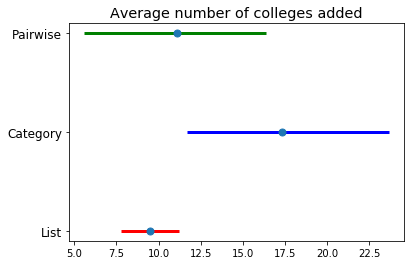

In [52]:
# use percentiles

boot = pd.DataFrame()
for m in modes:
    boot[m] = bootstrap_mean(adds[m], 1000)
mean = boot.mean()
err = []
err.append((boot.apply(lambda x : np.percentile(x, (5))) - mean).abs())
err.append(boot.apply(lambda x : np.percentile(x, (95))) - mean)
plt.errorbar(mean, [0,1,2], xerr=err, fmt='o-',linestyle='none', ecolor=['red','blue','green'], elinewidth=3, markersize=7 )
plt.yticks([0,1,2], mean.index, size='large')
plt.title('Average number of colleges added', size='x-large')
# plt.show()
plt.savefig('results/add.png', bbox_inches='tight')

In [53]:
# count number of time switching between build and explore
res['interaction'].unique()

array(['PREVIOUS', 'ADD', nan, 'QUESTION', 'MED ADD', 'LOW ADD',
       'HIGH ADD', 'LEFT ADD', 'LEFT REMOVE', 'SUBMIT SUCCESFUL', 'REMOVE',
       'SORT', 'RIGHT ADD', 'FINISH', 'NEW PAIR', 'RANK', 'FINISH TEST',
       'MED REMOVE', 'SHUFFLE', 'SUBMIT FAIL', 'HIGH REMOVE', 'LOW REMOVE'], dtype=object)

In [54]:
df =res.drop_duplicates(subset=['workerId'])
counts = df[['workerId', 'mode']].groupby(['mode']).count()
counts

,workerId
mode,
Category,12
List,13
Pairwise,5


In [55]:
counts['workerId']['List']

13

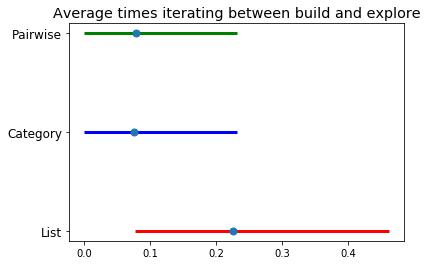

In [56]:
boot = pd.DataFrame()
for m in modes:
    df = res[res['mode'] == m]
    c = np.array(df[df['interaction']=='PREVIOUS'][['workerId','interaction']].groupby('workerId').count())
    # get total number 
    num = counts['workerId']['List'] - c.shape[0]
    # adjust average to include those who don't ever iterate
    c = np.append(c, np.zeros(num))
    boot[m] = bootstrap_mean(c, 1000)

mean = boot.mean()
err = []
err.append((boot.apply(lambda x : np.percentile(x, (5))) - mean).abs())
err.append(boot.apply(lambda x : np.percentile(x, (95))) - mean)
plt.errorbar(mean, [0,1,2], xerr=err, fmt='o-',linestyle='none', ecolor=['red','blue','green'], elinewidth=3, markersize=7 )
plt.yticks([0,1,2], mean.index, size='large')
plt.title('Average times iterating between build and explore', size='x-large')
# plt.show()
plt.savefig('results/iterate.png', bbox_inches='tight')